# Molecule Energies with VQE

In this notebeook we show you how to use the VQE routine for a more advanced usage: **Estimating the ground state energy of a molecule**, namely $H_2$. 

The ground state energy **reveals importatnt physical-chemical characteristics** of a molecule.

## Imports - Helper functions

Nothing special here :).

In [2]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import qiskit_nature
from qiskit_aer import AerSimulator
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_algorithms.optimizers import COBYLA
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeOsaka
qiskit_nature.settings.use_pauli_sum_op = False
with open('../../api_key.txt', 'r') as file:
    token = file.read()
    
service = QiskitRuntimeService(channel='ibm_quantum',token=token)


In [3]:
import warnings
warnings.simplefilter(action='ignore')

## Defining the optimization problem

This time our optimization problem is derived from a molecular configuration. 

We can use the `qiskit_nature` framework to **convert the molecular configuration to an observable** that can be measured with a Quantum Computer. 

("We all stand on the shoulders of giants." - Isaac Newton)

For reusability we define the evaluation of the molecular configuartion observable as function of interatomic distance.

In [4]:
# Convert the molecular configuration problem to an observable
def get_qubit_op(dist):
    # Define molecule

    # Your code goes here: 
    molecule = MoleculeInfo(
        symbols=['H','H'],
        coords=([0,0,0],[0,0,dist]),
        multiplicity=1,
        charge=0,
        units=DistanceUnit.BOHR
    )
    
    driver = PySCFDriver.from_molecule(molecule)

    # Get molecule properties
    problem = driver.run()
    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals
    
    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [5]:
qubit_op, num_particles, num_spatial_orbitals, problem, mapper = get_qubit_op(1.2)
print('Problem observable:\n',
      f'{qubit_op}')

Problem observable:
 SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.0223402 +0.j,  0.46660537+0.j, -0.46660537+0.j, -0.01188374+0.j,
  0.17553258+0.j])


**Note:**

The observable that corresponds to the molecular configuration of $H_2$ is the sum of the Identity and Pauli-X,Y,Z matrices.

## Defining the ansatz

Again our ansatz is a parameterized Quantum Circuit.

We are using an ansatz that is specifically designed for finding the molecule ground state energy -> UCCD. 

This ansatz requires more qubits, has more circuit layers and also more tunable parameters.

In [6]:
reference_state = HartreeFock(
    num_spatial_orbitals,
    num_particles,
    mapper
)

var_form = UCCSD(
    num_spatial_orbitals=num_spatial_orbitals,
    num_particles=num_particles,
    qubit_mapper=mapper,
    initial_state=reference_state,
    
)

Let's see some properties of our ansatz:


Ansatz circuit properties:
   Detph: 15
   N-Qubits: 2
   Tunable Parameters: 3


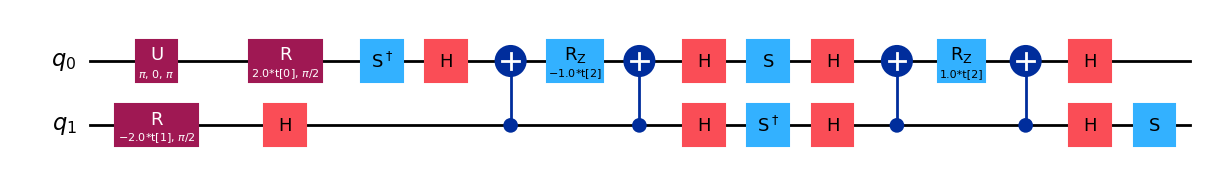

In [12]:
print('\nAnsatz circuit properties:\n',
    f'  Detph: {var_form.decompose(reps=3).depth()}\n',
    f'  N-Qubits: {var_form.width()}\n',
    f'  Tunable Parameters: {var_form.num_parameters}')
var_form.decompose(reps=3).draw("mpl")

## Defining the solver routine

We can use the qiskit `VQE` class for a simplified interface.

To estimat the exact results of the $H_2$ ground state energies we will use the `NumPyMinimumEigensolver` - a classical sover routine. 

In [14]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

def get_ansatz(num_particles, num_spatial_orbitals, mapper):

    # Define a function that creates the Ansatz as a composition of 
    # a reference state and a variational form circuit: 

    # Your code goes here:
    
    return var_form

def quantum_solver(qubit_op,var_form,problem,estimator,optimizer=None):  
    if optimizer == None: 
        optimizer = COBYLA(maxiter=20)

    ## Your code geoes here ##
    vqe = VQE(estimator=estimator,
              ansatz=var_form,
              optimizer=optimizer,
              initial_point=[0]*var_form.num_parameters)
    
    vqe_calc=vqe.compute_minimum_eigenvalue(operator=qubit_op)
    vqe_result=problem.interpret(vqe_calc).total_energies[0].real

    return vqe_result

## Setting the backend

We can use a **classical** compute resources to **simulate noisy quantum** computers.

This will accurately reflect the noise of a specific IBM Quantum computer.

**Note:**
- We can specify our error mitigation strategy by setting the `resilience_level`.

In [15]:
real_backend = service.backend('ibm_brisbane')
sim_backend = AerSimulator.from_backend(real_backend)
sim_backend

AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['sx', 'ecr', 'reset', 'id', 'x', 'measure']>)

In [16]:
pm_bad = generate_preset_pass_manager(backend=sim_backend, optimization_level=0)
pm_good = generate_preset_pass_manager(backend=sim_backend, optimization_level=3)

## Evaluating the $H_2$ ground state energy.

We will evaluate the ground state for a specific interatomic distance $d = 1.2$ Bohr between the H atoms.

Recent advancements in the Quantum Computing software and hardware stack allow to mitigate the errors of todays noisy quantum compoters by specifying the `resilience_level`.

Let's compare the **exact evaluations** to the **noisy results (no error mitigation - resilience_level = 0)** and the **error mitigated results (ZNE error mitigation - resilience_level = 2)**.

In [19]:
dist = 1.2
exact_energies = []
vqe_energies_noisy = []
vqe_energies_mitigated = []

# Set up the evaluation of the molecule ground state

with Session(backend=sim_backend) as session:
    estimator_noisy = Estimator(session=session,options={"resilience_level": 0})
    estimator_mitigated = Estimator(session=session,options={"resilience_level": 2})
    
    # Prepare problem
    # Your code goes here:
    qubit_op, num_particles, num_spatial_orbitals
        
    # Solve problem exactly
    # Your code goes here:
    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    
    # Prepare VQE ansatz
    # Your code goes here:
    var_form = get_ansatz(num_particles, num_spatial_orbitals, mapper)
    
    # Transpile ansatz and operator
    # Your code goes here:
    isa_var_from_good = pm_good.run(var_form)
    isa_qubit_op_good=qubit_op.apply_layout(layout=isa_var_from_good.layout)
    isa_var_from_bad= pm_bad.run(var_form)
    isa_qubit_op_bad=qubit_op.apply_layout(layout=isa_var_from_bad.layout)
    
    # Solve VQE - noisy
    # Your code goes here:
    vqe_result_noisy = quantum_solver(isa_qubit_op_bad,isa_var_from_bad,problem,estimator_noisy)
    vqe_energies_noisy.append(vqe_result_noisy)
    
    # Solve VQE - mitigated (ZNE)
    # Your code goes here:
    vqe_result_mitigated = quantum_solver(isa_qubit_op_good,isa_var_from_good,problem,estimator_mitigated)
    vqe_energies_mitigated.append(vqe_result_mitigated)

    print(
        f"\nInteratomic Distance: {np.round(dist, 2)} (Hartree)\n",
        f"Noisy VQE Result: {vqe_result_noisy:.5f} (Hartree)\n",
        f"Mitigated VQE Result: {vqe_result_mitigated:.5f} (Hartree)\n",
        f"Exact Energy: {exact_energies[-1]:.5f} (Hartree)\n",
    )

TypeError: Estimator.__init__() got an unexpected keyword argument 'mode'

## P-set 5

1. 80 points

Infer the ground state energy of $H_2$ for a series of interatomic distances $0.4 < d < 6$ (Bohr) and
plot the ground state energy as function of interatomic distances. (use Qiskit)

2. 20 points
   
At what distance is the molecule most stable? (Answere in markdown cell)


Try to execute 1. on a real Quantum Computer. Note that IBM Quantum grants free access to 127 qubit systems for 10 min/month. This might confine the number of steps used in your optimizer.

Hint: Before executin your code check which system is least busy.